In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Loading and Preprocessing the Video

### Loading the Video

In [2]:
video_path = 'cars.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

In [3]:
# Initialize MOG2 Background subtractor
backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=50, detectShadows=True)


### Reading Frames and Preprocessing

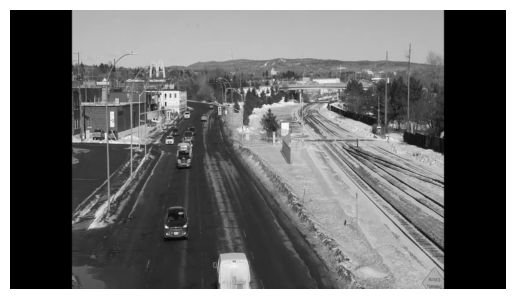

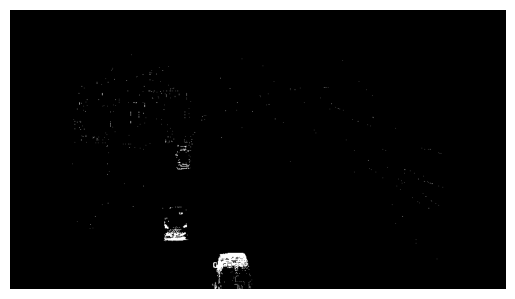

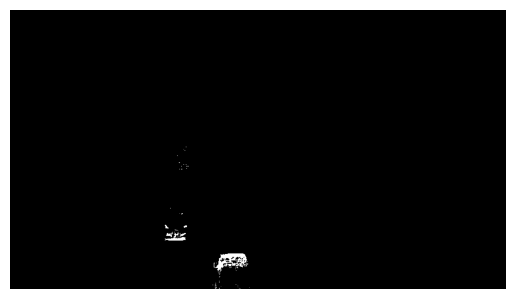

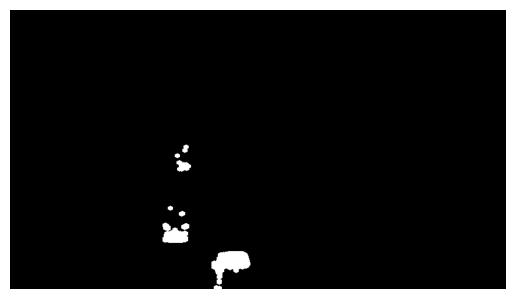

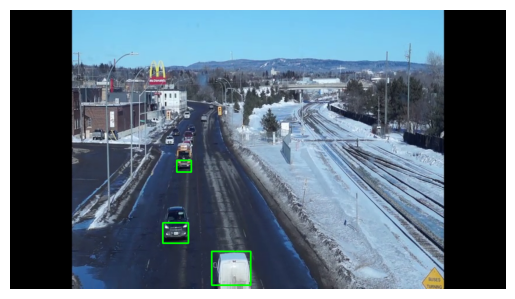

In [27]:
# Display an image
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Read the first frame
ret, frame = cap.read()
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

if ret:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply background subtraction
    fgMask = backSub.apply(gray_frame)
    fgMask_erode = cv2.erode(fgMask, kernel_erode, iterations=1)
    _, fgMask_shadow_removed = cv2.threshold(fgMask_erode, 127, 255, cv2.THRESH_BINARY)
    fgMask_dilated = cv2.dilate(fgMask_shadow_removed, kernel_dilate, iterations=2)

    # Countour edtection
    contours, _ = cv2.findContours(fgMask_dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if cv2.contourArea(contour) > 200:
            x, y , w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)

            if 0.5 < aspect_ratio < 5:
                cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0), 2)

    # Display the frame
    display_image(gray_frame)
    display_image(fgMask)
    display_image(fgMask_erode)
    display_image(fgMask_dilated)
    display_image(frame)
    
    
else:
    print("Error: Could not read frame.")


### Looping through the Video

In [ ]:
while True:
    ret, frame = cap.read()
    
    if not ret:
        break

    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Apply background subtraction
    fgMask = backSub.apply(gray_frame)

    # Display the grayscale frame 
    display_image(gray_frame)

# Release the video capture object
cap.release()

# 2nd try (good one)

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Display an image
def display_image(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

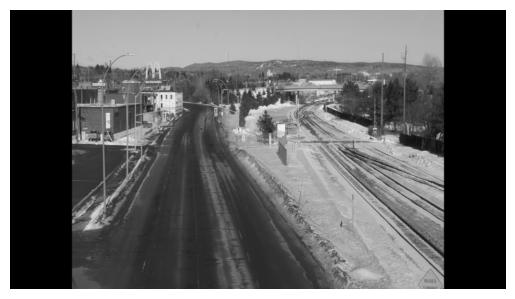

In [22]:
video_path = 'cars.mp4'
cap = cv2.VideoCapture(video_path)

frame_sum = None
frame_number = 900

# Read and extract the frame
for i in range(frame_number):
    ret, frame = cap.read()

    if not ret:
        print(f"Error: Could not read frame {frame_number}.")
        exit()
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
    if frame_sum is None:
        frame_sum = gray_frame
    else:
        frame_sum += gray_frame

averag_background = frame_sum / frame_number
averag_background = np.uint8(averag_background)
display_image(averag_background)

In [39]:
# Read the first frame
ret, frame = cap.read()
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))
kernel_dilate = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

if ret:
    # Convert the frame to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    frame_delta = cv2.absdiff(gray_frame, averag_background)

    _, threshold = cv2.threshold(frame_delta, 30, 255, cv2.THRESH_BINARY)

    thresh_erode = cv2.erode(threshold, None, iterations=1) # Originally 1
    thresh_dilate = cv2.dilate(thresh_erode, None, iterations=3) # Originally 2

    # Countour detection
    contours, _ = cv2.findContours(thresh_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[1], reverse=True)  # Sort by y position

    # Here we'll store the filtered bounding boxes
    filtered_boxes = []

    for contour in contours:
        if cv2.contourArea(contour) > 200:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = w / float(h)

            if 0.2 < aspect_ratio < 6:
                # Check if the current box overlaps with any previous box
                overlaps = False
                for prev_box in filtered_boxes:
                    prev_x, prev_y, prev_w, prev_h = prev_box
                    # Check for overlap
                    if (x < prev_x + prev_w and x + w > prev_x and y < prev_y + prev_h and y + h > prev_y):
                        overlaps = True
                        # Determine which box to keep. Prefer the lower (hence likely larger) box
                        if y > prev_y or (y == prev_y and h > prev_h):
                            filtered_boxes.remove(prev_box)
                            filtered_boxes.append((x, y, w, h))
                        break
                if not overlaps:
                    filtered_boxes.append((x, y, w, h))

    # Draw the filtered bounding boxes
    for x, y, w, h in filtered_boxes:
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the frame
     
    #display_image(gray_frame)
    #display_image(frame_delta)
    #display_image(threshold)
    #display_image(thresh_erode)
    #display_image(thresh_dilate)
    display_image(frame)
    
else:
    print("Error: Could not read frame.")

Error: Could not read frame.
